# Using Correlated-K Tables vs. Monochromatic Opacities

Throughout the tutorials, we have always used monochromatic opacities. If you are interested in switching to correlated-K tables versus using the currently provided opacities on Zenodo, that is possible. Here you will learn:

1. Running forward model with pre-weighted tables vs resort rebin vs resampled monochromatic opacities

Before completing this notebook you will have to:

1. [Download at least one or multiple of the k-table folder](https://doi.org/10.5281/zenodo.18636725)
    File should be of the format `sonora_2121grid_feh+XXX_co_YYY`, where XXX defines the Fe/H and YYY describes the C/O ratio


2. [Download Sonora PT profiles](https://zenodo.org/record/1309035#.Y1MHYezMLvW) (if this is unfamiliar please see [Brown Dwarf Tutorial](https://natashabatalha.github.io/picaso/notebooks/6_BrownDwarfs.html))

3. [Download PICASO Correlated-K's for On-the-Fly Disequilibrium Climate Calculations
](https://doi.org/10.5281/zenodo.18644980) (see [Brown Dwarf Tutorial](https://natashabatalha.github.io/picaso/notebooks/climate/12a_BrownDwarf.html))


These are all easily retrieved through the `data.get_data` function:

>>import picaso.data as d

>> d.get_data(category_download='sonora_grids',target_download='bobcat')

>> d.get_data(category_download='ck_tables',target_download='pre-weighted')

>> d.get_data(category_download='ck_tables',target_download='by-molecule')

## What are correlated-k tables vs. monochromatic opacities

1. Pre-weighted correlated k tables : these are preweighted on chemical equilibrium tables and as such you will get on table per M/H and C/O point
2. Resort Rebin correlated k tables : these are the ones downloaded for on-the-fly disequilibrium and are mixed "on the fly" based on your chemistry. Therefore you will see they are on a per molecule basis.
3. Monochromatic opacities: these are resampled from line by line calculations and you will notice they are usually very large (10-30 Gb)



In [1]:
import os

ck_db_path = os.path.join(os.getenv('picaso_refdata'),'opacities', 'preweighted','sonora_2121grid_feh1.0_co0.46.hdf5')
sonora_profile_db = os.path.join(os.getenv('picaso_refdata'),'sonora_grids','bobcat')

In [2]:
from picaso import justdoit as jdi
from picaso import justplotit as jpi
jpi.output_notebook()

import matplotlib.pyplot as plt
from itertools import cycle
from matplotlib.lines import Line2D
import numpy as np

Loading BokehJS ...

In [3]:
opacity_mono         = jdi.opannection() #defaults, method='resampled, and default opacities db file
opacity_ck           = jdi.opannection(method='preweighted',
                                       ck_db=str(ck_db_path)
                                       )

# This requires the climate_INPUTS directory, and associated data
# See https://natashabatalha.github.io/picaso/notebooks/climate/12c_BrownDwarf_DEQ.html
# They should be in the references dir
gases_fly = ['CO','CH4','H2O','NH3','CO2','N2','HCN','H2','PH3','C2H2','Na','K','TiO','VO','FeH']
opacity_resortrebin =  jdi.opannection(method='resortrebin',
                                       preload_gases=gases_fly)#you can also supply "all" to preload_gas and it will load every file you have downloaded

## Call `opannection` and supply a correlated-k table

Notice that when we call the `opannection` with the `ck=True`, we must also pass it one of the directories from Zenodo. The directory name describes the chemistry that this has been calculated for. The `ck_db` we have defined  is for 1xSolar, Solar C/O.



You should already be familiar with the following code block. Here we are loading the input class, setting the gravity, stellar parameters, and sonora profile.

In [4]:
# Create a dictionary that contains all the different calc types
calc = {'ck':opacity_ck,
        'mono':opacity_mono,
        'resort':opacity_resortrebin}
cases = {i: jdi.inputs() for i in calc.keys()}

# Phase angle
for i in calc.keys(): cases[i].phase_angle(0) #radians

# Define gravity
for i in calc.keys(): cases[i].gravity(radius=1,
                                    radius_unit=jdi.u.Unit('R_jup'),
                                    mass=1,
                                    mass_unit=jdi.u.Unit('M_jup'))

# Define star
for i in calc.keys(): cases[i].star(calc[i],
                                    5000,
                                    0,
                                    4.0,
                                    radius=1,
                                    radius_unit=jdi.u.Unit('R_sun'),
                                    semi_major=5,
                                    semi_major_unit=jdi.u.Unit('au'))


# Just grabbing any Teff so we can use a sonora pressure-temperature profile
Teff = 1000
for i in calc.keys():cases[i].sonora(str(sonora_profile_db), Teff, chem='grid')

The differences between the two procedures comes in when we specify the chemistry. Here we introduce a new function called `premix_atmosphere`. This is going to pull the precomputed chemistry that was used to compute the correlated k tables.

In [5]:
# Figure out here from fun with chem
cases['ck'].premix_atmosphere(calc['ck'])

# Now let's pass that to the monochromatic opacities for consistency
cases['mono'].atmosphere(df=cases['ck'].inputs['atmosphere']['profile'])

# Set identical atmosphere for the resorted ck, if desired.
cases['resort'].atmosphere(df=cases['ck'].inputs['atmosphere']['profile'])

/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/pandas/core/internals/blocks.py:347: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


In [6]:
df = {}

# Run picaso with each of the cases
df['ck'] = cases['ck'].spectrum(calc['ck'],full_output=True, calculation='thermal')
df['mono'] = cases['mono'].spectrum(calc['mono'],full_output=True, calculation='thermal')
df['resort'] = cases['resort'].spectrum(calc['resort'],full_output=True, calculation='thermal')

## Compare the optical depth for various layers

One big difference you will notice between `taugas` for a monochromatic opacity calculation and a correlated-k calculation, is that `taugas` will have an extra dimension for CK. Those correspond to each of the gauss points. Now, be careful not to confuse the gauss points that we use for the disk integration and these gauss points. They are different!

Below is an example of summing the `tau`'s in order to compare with the monochromatic opacities.

This compares the mono case, the premixed correlated-k case, and the disequilibrium chemistry correlated-k case

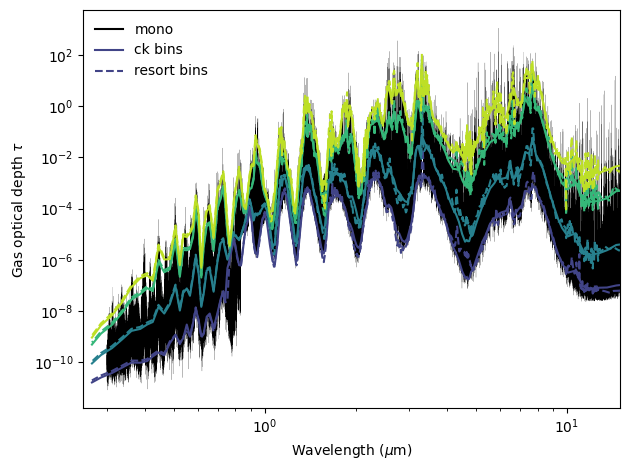

In [7]:

cm1_to_micron = lambda wn: 1e4 / wn

# Num gauss points is based on the opacities that you're using
num_gauss_points = 8
gauss_to_plot    = range(0, num_gauss_points, 2)
cmap             = plt.cm.viridis
colors           = cmap(np.linspace(0.2, 0.9, len(gauss_to_plot)))

wl_mono  = cm1_to_micron(df['mono']['wavenumber'])
wl_ck    = cm1_to_micron(df['ck']['wavenumber'])
wl_resort = cm1_to_micron(df['resort']['wavenumber'])

fig, ax = plt.subplots()

ax.plot(wl_mono,
        df['mono']['full_output']['taugas'][0],
        color='black', lw=0.1, alpha=1, label='mono')

# CK = solid, resort = dashed; color varies per Gauss index
for j, i in enumerate(gauss_to_plot):
    clr = colors[j]
    ax.plot(wl_ck,    df['ck']['full_output']['taugas'][0, :, i], lw=1.5, ls='-', color=clr)
    ax.plot(wl_resort, df['resort']['full_output']['taugas'][0, :, i], lw=1.5, ls='--', color=clr)

# axes formatting
ax.set(xscale='log', yscale='log',
       xlim=(0.25, 15),
       xlabel=r'Wavelength ($\mu$m)',
       ylabel=r'Gas optical depth $\tau$')

# legend with uniform linewidth
leg_lw = 1.5
legend_handles = [
    Line2D([], [], color='black',  lw=leg_lw, ls='-',  label='mono'),
    Line2D([], [], color=colors[0], lw=leg_lw, ls='-',  label='ck bins'),
    Line2D([], [], color=colors[0], lw=leg_lw, ls='--', label='resort bins'),
]
ax.legend(handles=legend_handles, frameon=False)

plt.tight_layout()
plt.show()

## Compare Chemistry

In this case we supplied it the same chemistry. However, there may be cases where you want to extract the chemistry from the pre-computed files. This is how you would go about doing so.

For the below code snippet, I am pulling out the abundances that are higher than 0.1 ppm.

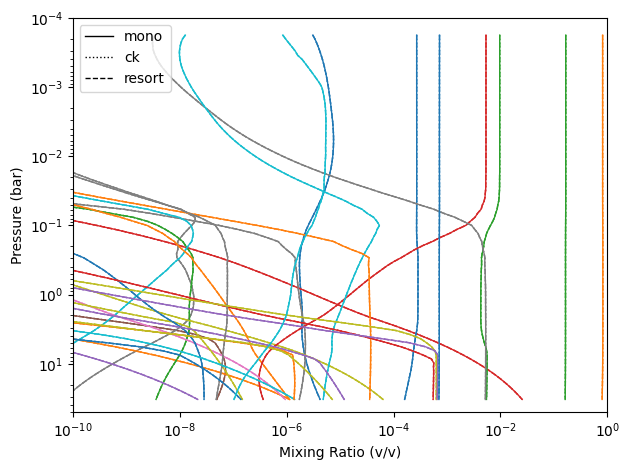

In [8]:
styles = {'mono': '-', 'ck': ':', 'resort': '--'}
colors = cycle(plt.cm.tab10.colors)

fig, ax = plt.subplots()
ax.set(xscale='log', yscale='log', xlim=(1e-10, 1), ylim=(50, 1e-4), xlabel='Mixing Ratio (v/v)', ylabel='Pressure (bar)')

species = {c for k in styles for c in cases[k].inputs['atmosphere']['profile'].columns if c not in ('pressure', 'temperature')}

for clr, sp in zip(colors, species):
    for case, ls in styles.items():
        df = cases[case].inputs['atmosphere']['profile']
        x = df.get(sp)
        if x is not None and x.max() > 1e-8:
            ax.plot(x, df['pressure'], color=clr, ls=ls, lw=1)

ax.legend([Line2D([], [], color='k', lw=1, ls=ls) for ls in styles.values()], styles.keys())
plt.tight_layout()

## Reading Correlated-K Tables directly from the file 

If you want to subvert opannection you can also use opacity_factory to get out the info from our correlated-k tables. 

In [9]:
import picaso.opacity_factory as opaf

In [10]:
ck_db_path = os.path.join(os.getenv('picaso_refdata'),'opacities', 'preweighted','sonora_2121grid_feh1.0_co0.46.hdf5')

output_preweighted = opaf.get_ck_tables(ck_db_path)

directory_to_resortrebin = os.path.join(os.getenv('picaso_refdata'),'opacities', 'resortrebin')

#read data for just H2O and CH4  (you could also just say "all" to load in all molecules)
output_by_molecule = opaf.get_ck_tables(directory_to_resortrebin, preload_gases=['H2O','CH4'])



In [11]:
output_by_molecule.keys()

dict_keys(['kappas', 'wno', 'nwno', 'delta_wno', 'pressures', 'temps', 'gauss_pts', 'gauss_wts', 'nc_p', 'ngauss', 'molecules'])